## Imports

In [51]:
import os
import random
import re
import string

import nltk

import numpy as np
import pandas as pd


from collections import Counter 

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")
nltk.download('punkt')

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to /Users/denis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/denis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read data

In [52]:
df_raw = pd.read_csv("data/news_data.csv")

In [53]:
df_raw.sample(3)

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
8005,8005,cbs-news,CBS News,Emily Tillett,"300 former officials call out Trump for ""uncon...",Group of bipartisan national security experts ...,https://www.cbsnews.com/news/donald-trump-ukra...,https://cbsnews2.cbsistatic.com/hub/i/r/2017/0...,2019-09-27T12:17:01Z,More than 300 former national security officia...,0.0,14330.0,6414.0,4197.0,0.0
9495,9495,cnn,CNN,"Jason Hanna and Aaron Cooper, CNN",WWII-era bomber crashes at an airport near Har...,A World War II-era aircraft crashed Wednesday ...,https://www.cnn.com/2019/10/02/us/connecticut-...,https://cdn.cnn.com/cnnnext/dam/assets/1910021...,2019-10-02T14:35:10Z,NaN,0.0,3373.0,988.0,1265.0,0.0
7428,7428,business-insider,Business Insider,"lramsey@businessinsider.com (Lydia Ramsey), Ly...",Dispensed: Amazon and Best Buy's expanding hea...,"REUTERS/Joshua Roberts Hello, There must be so...",https://www.businessinsider.com/dispensed-week...,https://image.businessinsider.com/5c2f7f05bd77...,2019-09-27T14:13:56Z,"Hello,\nThere must be something in the water t...",0.0,0.0,0.0,1627.0,0.0


## Clean data

### Define function to clean and tokenize

In [54]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

### Apply function and remove duplicates

In [55]:
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
text_columns = ["title", "description", "content"]

df = df_raw.copy()
df["content"] = df["content"].fillna("")

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (10437, 15)
Pre-processed dataframe: (9882, 2)


### Check vocabulary

In [56]:
docs = df["text"].values
tokenized_docs = df["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [57]:
vocab.most_common(10)

[('us', 2757),
 ('said', 2519),
 ('year', 1781),
 ('president', 1756),
 ('trump', 1705),
 ('world', 1620),
 ('says', 1511),
 ('one', 1418),
 ('two', 1284),
 ('first', 1195)]

## Train Word2Vec Model

In [24]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

In [206]:
model.wv.most_similar("trump")

[('trumps', 0.988541841506958),
 ('president', 0.9746493697166443),
 ('donald', 0.9274922013282776),
 ('ivanka', 0.9203903079032898),
 ('impeachment', 0.9195784330368042),
 ('pences', 0.9152231812477112),
 ('avlon', 0.9148306846618652),
 ('biden', 0.9146010279655457),
 ('breitbart', 0.9144087433815002),
 ('vice', 0.9067237973213196)]

## Generate vectors from document

### Define function for creating a single vectors from word embeddings

In [207]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

### Apply function to previously pre-processed text

In [208]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(9882, 100)

### Generate and analyze clusters

In [209]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [210]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=50, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 50
Silhouette coefficient: 0.11
Inertia:3567.650253048523
Silhouette values:
    Cluster 25: Size:49 | Avg:0.40 | Min:0.06 | Max: 0.59
    Cluster 2: Size:139 | Avg:0.31 | Min:-0.04 | Max: 0.50
    Cluster 17: Size:90 | Avg:0.27 | Min:-0.10 | Max: 0.50
    Cluster 19: Size:96 | Avg:0.27 | Min:-0.01 | Max: 0.45
    Cluster 28: Size:105 | Avg:0.25 | Min:-0.05 | Max: 0.48
    Cluster 30: Size:57 | Avg:0.24 | Min:-0.06 | Max: 0.48
    Cluster 48: Size:78 | Avg:0.23 | Min:-0.07 | Max: 0.43
    Cluster 32: Size:59 | Avg:0.22 | Min:-0.00 | Max: 0.44
    Cluster 23: Size:80 | Avg:0.20 | Min:0.03 | Max: 0.40
    Cluster 13: Size:123 | Avg:0.19 | Min:-0.06 | Max: 0.40
    Cluster 26: Size:219 | Avg:0.19 | Min:-0.06 | Max: 0.40
    Cluster 44: Size:133 | Avg:0.19 | Min:-0.07 | Max: 0.39
    Cluster 3: Size:153 | Avg:0.18 | Min:-0.04 | Max: 0.40
    Cluster 41: Size:557 | Avg:0.18 | Min:-0.02 | Max: 0.40
    Cluster 16: Size:437 | Avg:0.17 | Min:-0.02 | Max: 0.38
    Cluster 45: S

In [211]:
print("Top terms per cluster (based on centroids):")
for i in range(50):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: panel hill buttigieg rogue opposing 
Cluster 1: boats collapsed cause mosquito families 
Cluster 2: pm proposals delay johnsons benjamin 
Cluster 3: malone likes benefits rainforest passenger 
Cluster 4: murdering girl neighbor convicted manslaughter 
Cluster 5: amid delegation erdogan undermine envoy 
Cluster 6: tournament injury beat victory finished 
Cluster 7: professional edition virtual ones expensive 
Cluster 8: category humberto tropical landfall strengthened 
Cluster 9: urged shareholder repeal renewed prisoners 
Cluster 10: hospital indiana identified knife rioting 
Cluster 11: speech dominic israels block suspend 
Cluster 12: followed asian sep hire gain 
Cluster 13: cnnpolitics clinton complaint putin pences 
Cluster 14: sexually daughter teenage 20th disappearance 
Cluster 15: congressional vizcarra addressed aides claims 
Cluster 16: selection square jet orleans corps 
Cluster 17: tanker yemen ablaze arabian strikes 


In [212]:
test_cluster = 48
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Police: No evidence of shooting at northern Virginia mall | Get breaking national and world news, broadcast video coverage, and exclusive interviews. Find the top news online at ABC news. | Authorities in northern Virginia say they have found no evidence that a shooting occurred at a popular mall.
The Arlington County Police Department tweeted Saturday night that authorities were continuing to conduct a search at the Ballston Quarter mall in Ar… [+162 chars]
-------------
US woman arrested at Manila airport with baby hidden in bag | Get breaking national and world news, broadcast video coverage, and exclusive interviews. Find the top news online at ABC news. | An American woman who attempted to carry a 6-day-old baby out of the Philippines hidden inside a sling bag has been arrested at Manila's airport and charged with human trafficking, officials said Thursday.
They said Jennifer Talbot was able to pass through t… [+1496 chars]
-------------
Jury selection begins in killing of pregnan

## Train Doc2Vec Model

In [58]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_docs)]
modeldv = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=1)

In [59]:
modeldv.wv.most_similar("trump")

[('trumps', 0.9249901175498962),
 ('cowboy', 0.8774431347846985),
 ('hump', 0.8660275936126709),
 ('cerrone', 0.8378428220748901),
 ('nhtsa', 0.8215087056159973),
 ('sedated', 0.8198277354240417),
 ('purposefully', 0.8184893131256104),
 ('dewey', 0.8119789958000183),
 ('huey', 0.8104555010795593),
 ('atmospheric', 0.8077002763748169)]

## Generate vectors from document

### Define function for creating a single vectors from word embeddings

In [60]:
vectorized_docs = []
for i in range(len(tokenized_docs)):
    vectorized_docs.append(modeldv.infer_vector(tokenized_docs[i]))
len(vectorized_docs), len(vectorized_docs[0])

(9882, 100)

### Generate and analyze clusters

In [61]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [62]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=50, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 50
Silhouette coefficient: 0.02
Inertia:8569.727992439684
Silhouette values:
    Cluster 33: Size:7 | Avg:0.14 | Min:0.02 | Max: 0.29
    Cluster 19: Size:387 | Avg:0.12 | Min:0.03 | Max: 0.26
    Cluster 37: Size:149 | Avg:0.10 | Min:-0.06 | Max: 0.24
    Cluster 38: Size:127 | Avg:0.09 | Min:-0.16 | Max: 0.29
    Cluster 6: Size:375 | Avg:0.08 | Min:0.00 | Max: 0.19
    Cluster 31: Size:104 | Avg:0.07 | Min:-0.15 | Max: 0.28
    Cluster 43: Size:46 | Avg:0.07 | Min:-0.02 | Max: 0.19
    Cluster 9: Size:207 | Avg:0.07 | Min:-0.08 | Max: 0.22
    Cluster 24: Size:183 | Avg:0.06 | Min:-0.11 | Max: 0.21
    Cluster 27: Size:275 | Avg:0.06 | Min:-0.04 | Max: 0.21
    Cluster 8: Size:427 | Avg:0.05 | Min:-0.06 | Max: 0.17
    Cluster 49: Size:276 | Avg:0.05 | Min:-0.07 | Max: 0.17
    Cluster 32: Size:318 | Avg:0.04 | Min:-0.09 | Max: 0.17
    Cluster 11: Size:452 | Avg:0.04 | Min:-0.05 | Max: 0.15
    Cluster 4: Size:220 | Avg:0.04 | Min:-0.09 | Max: 0.18
    Cluster 20: 

In [63]:
print("Top terms per cluster (based on centroids):")
for i in range(50):
    tokens_per_cluster = ""
    most_representative = modeldv.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: candidate frontrunner representative singled senator 
Cluster 1: altered map alabama trajectory flahurricane 
Cluster 2: crisis companies data destroyers stock 
Cluster 3: receiver graphic posted spoof coverage 
Cluster 4: lauderdale port freeport helicopter engulfed 
Cluster 5: cypriot missile ballistic northeast breakaway 
Cluster 6: anne pike artist exploring dove 
Cluster 7: alleged cop osama orde kingsland 
Cluster 8: promote guys im maybe cowley 
Cluster 9: stocks markets growth flows global 
Cluster 10: app lite switch penthouse nintendo 
Cluster 11: driving clothes console messy ish 
Cluster 12: shares private stripe stake net1 
Cluster 13: murder guyger murdering amber groping 
Cluster 14: peace conclude talks obeying iran 
Cluster 15: vladimir volodymyr vice ukrainian omar 
Cluster 16: scrapping prorogue parliament proposals prorogation 
Cluster 17: beardsley englands singer abbey jofra 
Cluster 18: oil unloaded tanker pr

In [64]:
test_cluster = 33
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Fox News Poll Shows Trump Losing to Every Democratic Frontrunner - Newsweek | Fox News Poll Shows Trump Losing to Every Democratic Frontrunner Newsweek The polls are in: here’s who won — and lost — last week’s debate Vox.com One big lesson from the General Motors strike NJ.com Electability becomes a self-fulfilling prophecy The Washing… | The latest Fox News poll about the 2020 election shows President Donald Trump losing to every Democratic frontrunner including Joe Biden, Bernie Sanders and Elizabeth Warren.
The survey, which was conducted from September 15 to September 17, found that Biden… [+2580 chars]
-------------
Presidential resumes: We asked voters the qualities they want most in a president, and these are the 2020 Democratic candidates who look best on paper | Earlier this summer, Insider polled voters on what accomplishments made them more likely to vote for a presidential candidate. Democratic voters' most favored qualities included having released tax returns, gubernatori

## Поиск гиперпараметров по сетке

### поиск оптимального числа кластеров

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


distortions = []
K = range(1,100, 5)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(vectorized_docs)
    kmeanModel.fit(vectorized_docs)
    #distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    distortions.append(kmeanModel.inertia_)

Text(0, 0.5, 'distortions')

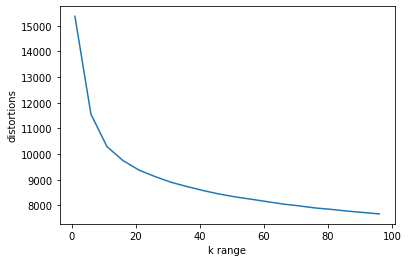

In [17]:
plt.plot(K, distortions)
plt.xlabel("k range")
plt.ylabel("distortions")

### поиск гипер параметров

Мы хотим подобрать лучшие параметры для моделей:


    Word2vec:
        vector_size
        
    Doc2ves:
        vector_size
        window_size

для проверки будем равнивать на сколько вектор title совпадает с вектором самого текста, найдем через косинусное расстояние

In [31]:
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
title_columns = ["title"]
text_columns = ["description", "content"]

df = df_raw.copy()
df["content"] = df["content"].fillna("")

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))
df["tokens_title"] = df["title"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["tokens_title", "tokens"]]

In [35]:
tokenized_docs = df["tokens"].values
tokenized_titles = df["tokens_title"].values

print(len(tokenized_titles))
print(len(tokenized_docs))

9687
9687


In [156]:
# создаем сетку параметров:
vector_size_range = range(1, 101, 5)

In [157]:
from scipy.spatial import distance


errors = []
for vector_size in vector_size_range:
    
    model = Word2Vec(sentences=tokenized_docs, vector_size=vector_size, workers=1, seed=SEED);
    
    vectorized_docs = vectorize(tokenized_docs, model)
    
    vectorized_titles = vectorize(tokenized_titles, model)
    
    error = 0
    for i in range(len(vectorized_docs)):
        error += distance.cosine(vectorized_docs[i], vectorized_titles[i])
    print(error)
    errors.append(error)

10.00020682811737
485.5487731397152
528.0472649633884
551.2801556885242
535.52222058177
541.3496044576168
522.5107842087746
520.0321653187275
513.6182690262794
503.6405604183674
497.6023508012295
494.225977152586
489.16013088822365
490.7323587536812
479.46621203422546
477.13446524739265
472.41586071252823
474.5641686320305
472.1649237573147
462.9322186112404


In [141]:
!pip install -U matplotlib

     |████████████████████████████████| 7.2 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 7.6 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 61 kB 6.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/denis/Desktop/Summer_Practice/nlp-snippets/venv/bin/python3 -m pip install --upgrade pip' command.


Text(0, 0.5, 'sum of cosin distance')

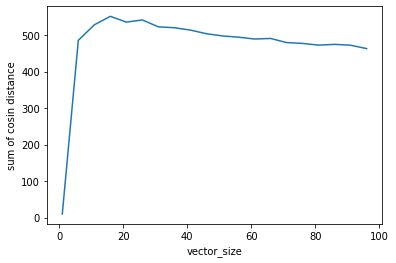

In [158]:
import matplotlib.pyplot as plt


plt.plot(vector_size_range, errors)
plt.xlabel("vector_size")
plt.ylabel("sum of cosin distance")

In [33]:
# создаем сетку параметров:
vector_size_range = range(30, 41, 10)
window_range = range(2, 10);

In [40]:
from scipy.spatial import distance


errors = []
for vector_size in vector_size_range:
    for j in window_range:
        model = Doc2Vec(documents, vector_size=vector_size, window=j, min_count=1, workers=1);
        
        vectorized_docs = []
        for i in range(len(tokenized_docs)):
            vectorized_docs.append(modeldv.infer_vector(tokenized_docs[i]))
    
        vectorized_titles = []
        for i in range(len(tokenized_titles)):
            vectorized_titles.append(modeldv.infer_vector(tokenized_titles[i]))
        error = 0
#         print(len(vectorized_docs))
#         prin(len(vectorized_titles))
        for i in range(len(vectorized_docs)):
            error += distance.cosine(vectorized_docs[i], vectorized_titles[i])
        print("vector_size: " + str(vector_size) + "    window: " + str(j))
        print(error)
        errors.append(error)

vector_size: 30    window: 2
3291.9446106333053
vector_size: 30    window: 3
3286.1870734925615
vector_size: 30    window: 4
3290.685852492552
vector_size: 30    window: 5
3296.4689709722297
vector_size: 30    window: 6
3279.1774203363602
vector_size: 30    window: 7
3278.672069430584
vector_size: 30    window: 8
3283.6640926465625
vector_size: 30    window: 9
3289.0930471369647
vector_size: 40    window: 2
3291.929179743165
vector_size: 40    window: 3
3288.4915898351173
vector_size: 40    window: 4
3282.974888044282
vector_size: 40    window: 5
3280.7907068335335
vector_size: 40    window: 6
3281.476655820268
vector_size: 40    window: 7
3276.880556948483
vector_size: 40    window: 8
3295.941181475253
vector_size: 40    window: 9
3288.687649303116


In [180]:
print(errors)

[227.4528568983078, 253.10591620206833, 287.1969421803951, 567.9930594861507, 669.1021638512611, 774.3597612679005, 704.1011917889118, 829.7611305117607, 946.2683489769697, 760.5852160155773, 880.709297567606, 998.9721635580063]


vector size = 30


Text(0, 0.5, 'sum of cosin distance')

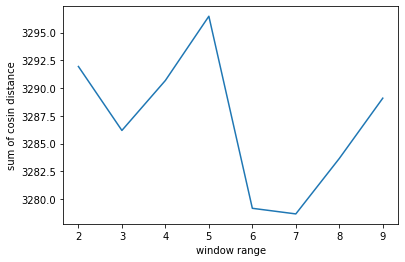

In [43]:
import matplotlib.pyplot as plt


print("vector size = 30")
plt.plot(window_range, errors[:8])
plt.xlabel("window range")
plt.ylabel("sum of cosin distance")

vector size = 40


Text(0, 0.5, 'sum of cosin distance')

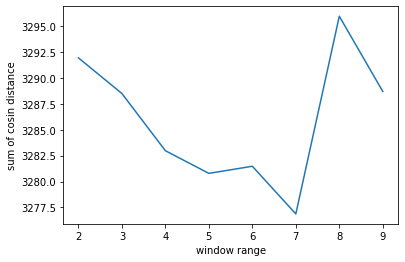

In [45]:
import matplotlib.pyplot as plt


print("vector size = 40")
plt.plot(window_range, errors[8:])
plt.xlabel("window range")
plt.ylabel("sum of cosin distance")

window = 4


Text(0, 0.5, 'sum of cosin distance')

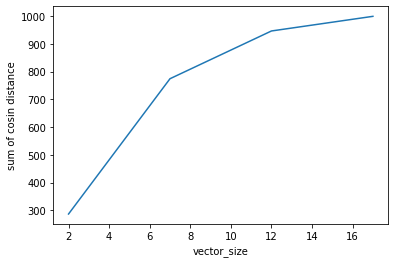

In [183]:
import matplotlib.pyplot as plt


print("window = 4")
plt.plot(vector_size_range, errors[2::3])
plt.xlabel("vector_size")
plt.ylabel("sum of cosin distance")

vector_size = 2


Text(0, 0.5, 'sum of cosin distance')

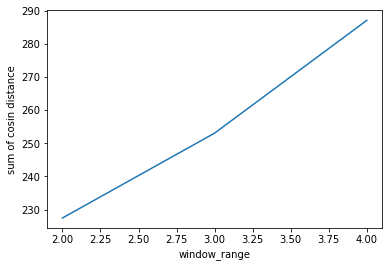

In [185]:
import matplotlib.pyplot as plt


print("vector_size = 2")
plt.plot(window_range, errors[:3])
plt.xlabel("window_range")
plt.ylabel("sum of cosin distance")

vector_size = 2


Text(0, 0.5, 'sum of cosin distance')

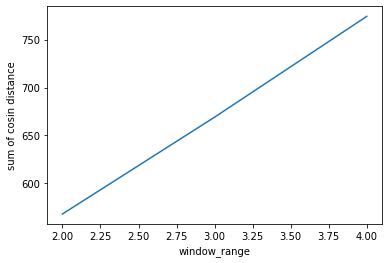

In [188]:
import matplotlib.pyplot as plt


print("vector_size = 7")
plt.plot(window_range, errors[3:6])
plt.xlabel("window_range")
plt.ylabel("sum of cosin distance")

vector_size = 2


Text(0, 0.5, 'sum of cosin distance')

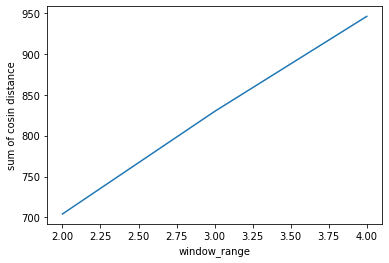

In [190]:
import matplotlib.pyplot as plt


print("vector_size = 12")
plt.plot(window_range, errors[6:9])
plt.xlabel("window_range")
plt.ylabel("sum of cosin distance")

vector_size = 17


Text(0, 0.5, 'sum of cosin distance')

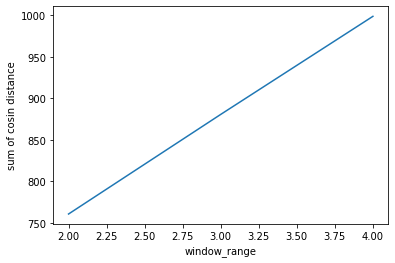

In [191]:
import matplotlib.pyplot as plt


print("vector_size = 17")
plt.plot(window_range, errors[9:12])
plt.xlabel("window_range")
plt.ylabel("sum of cosin distance")